<a href="https://colab.research.google.com/github/adinrizkii/INTELECTA/blob/main/NARRA_DataMining_Intelecta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL LIBRARY

In [ ]:
# Install library
!pip install pandas scikit-learn catboost lightgbm xgboost optuna numpy

In [ ]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_percentage_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
import gc

# IMPORT DATA

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path ke dataset di drive
train_df = pd.read_csv('/content/drive/MyDrive/INTELECTA/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/INTELECTA/test.csv')
sample_df = pd.read_csv('/content/drive/MyDrive/INTELECTA/sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

Analisis Data Eksploratif (EDA) mengungkapkan beberapa karakteristik kunci dari dataset.

## INFORMASI DATA

In [ ]:
#  Melihat jumlah baris dan kolom
print("Data Train :", train_df.shape)
print("Data Test :", test_df.shape)
print("Sample Submission:", sample_df.shape)

#  Menampilkan 5 baris pertama untuk melihat struktur data
print("\nMenampilkan 5 baris pertama data train:")
display(train_df.head())

print("\nMenampilkan 5 baris pertama data test:")
display(test_df.head())
# Informasi tipe data dan jumlah nilai non-null
print("\nInfo dataset train:")
train_df.info()

print("\nInfo dataset test:")
test_df.info()

# Ringkasan statistik
num_cols = train_df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = train_df.select_dtypes(include='object').columns.tolist()

print("\nRingkasan numerik data train")
display(train_df[num_cols].describe().T)

print("\nRingkasan kategorikal data train")
print("Kolom kategorikal:", cat_cols)
for c in cat_cols:
    print(f"\n[{c}] jumlah kategori unik:", train_df[c].nunique())
    display(train_df[c].value_counts(dropna=False).head(10))

# Cek duplikat
print("\nCek duplikat")
print("Duplikat baris train:", train_df.duplicated().sum())

# Cek range dan anomali
print("\nRange nilai")
for c in ['Total_Curah_Hujan_mm','Emisi_CO2_JT_Ton','Hasil_Panen_Ton_per_HA',
          'Akses_Irigasi','Penggunaan_Pestisida_KG_per_HA',
          'Penggunaan_Pupuk_KG_per_HA','Indeks_Kesehatan_Tanah','Suhu_Rata_Rata_C']:
    print(f"{c:35s} min={train_df[c].min():10.3f} | max={train_df[c].max():10.3f}")

print("\nCek nilai tak masuk akal")
print("Akses_Irigasi di luar [0,100] :", ((train_df['Akses_Irigasi']<0) | (train_df['Akses_Irigasi']>100)).sum())
print("Indeks_Kesehatan_Tanah di luar [0,100] :", ((train_df['Indeks_Kesehatan_Tanah']<0) | (train_df['Indeks_Kesehatan_Tanah']>100)).sum())

# Distribusi tahun
print("\nDistribusi tahun")
print("Rentang Tahun train:", train_df['Tahun'].min(), "→", train_df['Tahun'].max())
print("Rentang Tahun test :", test_df['Tahun'].min(),  "→", test_df['Tahun'].max())

print("\nJumlah setiap tahun (train):")
display(train_df['Tahun'].value_counts().sort_index())

print("\nJumlah setiap tahun (test):")
display(test_df['Tahun'].value_counts().sort_index())

# Hubungan Geografis dan tanaman
print("\nHubungan Geografis dan tanaman")
print("Jumlah Negara (train):", train_df['Nama_Negara'].nunique())
print("Jumlah Wilayah (train):", train_df['Wilayah'].nunique())
display(pd.crosstab(train_df['Wilayah'], train_df['Jenis_Tanaman']))



Data Train : (8000, 15)
Data Test : (2000, 14)
Sample Submission: (2000, 2)

Menampilkan 5 baris pertama data train:


,ID,Tahun,Nama_Negara,Wilayah,Jenis_Tanaman,Total_Curah_Hujan_mm,Emisi_CO2_JT_Ton,Hasil_Panen_Ton_per_HA,Kejadian_Cuaca_Ekstrim,Akses_Irigasi,Penggunaan_Pestisida_KG_per_HA,Penggunaan_Pupuk_KG_per_HA,Indeks_Kesehatan_Tanah,Strategi_Adaptasi,Suhu_Rata_Rata_C
0,0,2015,USA,South,Soybeans,1658.71,13.36,2.620,10,74.41,38.97,2.64,46.07,Manajemen Air,20.43
1,1,2022,China,East,Wheat,1478.74,9.55,0.570,2,36.90,49.99,77.22,88.87,Rotasi Tanaman,-0.33
2,2,2000,India,'West Bengal',Fruits,1252.34,27.37,2.115,3,34.21,2.75,83.94,77.15,Pertanian Organik,12.97
3,3,2008,Nigeria,'North West',Sugarcane,209.89,16.16,4.158,5,91.74,36.80,37.50,73.59,Pertanian Organik,12.81
4,4,1991,Canada,Ontario,Vegetables,1086.67,3.71,2.430,0,14.72,7.22,28.72,41.90,Tanpa Adaptasi,4.22



Menampilkan 5 baris pertama data test:


,ID,Tahun,Nama_Negara,Wilayah,Jenis_Tanaman,Total_Curah_Hujan_mm,Emisi_CO2_JT_Ton,Hasil_Panen_Ton_per_HA,Kejadian_Cuaca_Ekstrim,Akses_Irigasi,Penggunaan_Pestisida_KG_per_HA,Penggunaan_Pupuk_KG_per_HA,Indeks_Kesehatan_Tanah,Strategi_Adaptasi
0,8000,2022,Russia,Central,Fruits,1173.04,10.29,2.440,3,59.17,29.17,80.06,74.93,Tanpa Adaptasi
1,8001,1993,Brazil,South,Rice,310.08,13.90,3.276,2,60.59,4.76,70.63,97.59,Tanpa Adaptasi
2,8002,1998,India,Maharashtra,Soybeans,1348.17,12.90,2.620,3,90.93,5.95,63.87,74.81,Tanaman Tahan Kekeringan
3,8003,2010,Russia,Volga,Soybeans,1732.43,23.82,3.717,4,35.11,7.49,81.81,87.01,Rotasi Tanaman
4,8004,1998,Canada,'British Columbia',Sugarcane,2242.77,28.92,2.034,6,68.75,43.35,48.14,64.22,Manajemen Air



Info dataset train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              8000 non-null   int64  
 1   Tahun                           8000 non-null   int64  
 2   Nama_Negara                     8000 non-null   object 
 3   Wilayah                         8000 non-null   object 
 4   Jenis_Tanaman                   7781 non-null   object 
 5   Total_Curah_Hujan_mm            7821 non-null   float64
 6   Emisi_CO2_JT_Ton                8000 non-null   float64
 7   Hasil_Panen_Ton_per_HA          7800 non-null   float64
 8   Kejadian_Cuaca_Ekstrim          8000 non-null   int64  
 9   Akses_Irigasi                   7819 non-null   float64
 10  Penggunaan_Pestisida_KG_per_HA  8000 non-null   float64
 11  Penggunaan_Pupuk_KG_per_HA      8000 non-null   float64
 12  Indeks_Keseha

,count,mean,std,min,25%,50%,75%,max
ID,8000.0,3999.500000,2309.545410,0.00,1999.7500,3999.500,5999.2500,7999.00
Tahun,8000.0,2007.032750,10.106035,1990.00,1998.0000,2007.000,2016.0000,2024.00
Total_Curah_Hujan_mm,7821.0,1615.503060,807.932322,200.17,929.2900,1614.790,2316.8200,2999.67
Emisi_CO2_JT_Ton,8000.0,15.271184,8.551214,0.50,7.8600,15.250,22.8200,30.00
Hasil_Panen_Ton_per_HA,7800.0,2.238219,0.996626,0.45,1.4490,2.170,2.9300,5.00
Kejadian_Cuaca_Ekstrim,8000.0,4.989750,3.171814,0.00,2.0000,5.000,8.0000,10.00
Akses_Irigasi,7819.0,55.394575,26.034847,10.01,32.9050,55.340,77.7700,99.99
Penggunaan_Pestisida_KG_per_HA,8000.0,24.920015,14.454507,0.00,12.5500,24.930,37.3825,49.99
Penggunaan_Pupuk_KG_per_HA,8000.0,49.706654,28.674985,0.03,25.1600,49.270,74.4300,99.99
Indeks_Kesehatan_Tanah,8000.0,64.824446,20.153617,30.00,47.1150,64.675,82.3025,100.00



Ringkasan kategorikal data train
Kolom kategorikal: ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Strategi_Adaptasi']

[Nama_Negara] jumlah kategori unik: 10


,count
Nama_Negara,
USA,831
Nigeria,826
Australia,826
China,823
India,818
Canada,801
Argentina,772
Russia,771
France,771



[Wilayah] jumlah kategori unik: 34


,count
Wilayah,
South,617
Northeast,583
North,427
Central,370
Victoria,230
Punjab,222
'South East',219
Ontario,217
'New South Wales',216



[Jenis_Tanaman] jumlah kategori unik: 10


,count
Jenis_Tanaman,
Wheat,819
Cotton,801
Vegetables,791
Corn,789
Rice,782
Barley,776
Sugarcane,776
Fruits,758
Coffee,755



[Strategi_Adaptasi] jumlah kategori unik: 5


,count
Strategi_Adaptasi,
Manajemen Air,1647
Rotasi Tanaman,1589
Tanpa Adaptasi,1589
Pertanian Organik,1588
Tanaman Tahan Kekeringan,1587



Cek duplikat
Duplikat baris train: 0

Range nilai
Total_Curah_Hujan_mm                min=   200.170 | max=  2999.670
Emisi_CO2_JT_Ton                    min=     0.500 | max=    30.000
Hasil_Panen_Ton_per_HA              min=     0.450 | max=     5.000
Akses_Irigasi                       min=    10.010 | max=    99.990
Penggunaan_Pestisida_KG_per_HA      min=     0.000 | max=    49.990
Penggunaan_Pupuk_KG_per_HA          min=     0.030 | max=    99.990
Indeks_Kesehatan_Tanah              min=    30.000 | max=   100.000
Suhu_Rata_Rata_C                    min=    -4.990 | max=    35.000

Cek nilai tak masuk akal
Akses_Irigasi di luar [0,100] : 0
Indeks_Kesehatan_Tanah di luar [0,100] : 0

Distribusi tahun
Rentang Tahun train: 1990 → 2024
Rentang Tahun test : 1990 → 2024

Jumlah setiap tahun (train):


,count
Tahun,
1990,195
1991,252
1992,233
1993,220
1994,239
1995,223
1996,243
1997,223
1998,195



Jumlah setiap tahun (test):


,count
Tahun,
1990,55
1991,62
1992,41
1993,37
1994,66
1995,54
1996,52
1997,64
1998,44



Hubungan Geografis dan tanaman
Jumlah Negara (train): 10
Jumlah Wilayah (train): 34


Jenis_Tanaman,Barley,Coffee,Corn,Cotton,Fruits,Rice,Soybeans,Sugarcane,Vegetables,Wheat
Wilayah,,,,,,,,,,
'British Columbia',16,20,26,21,18,21,19,19,20,25
'Grand Est',17,15,15,28,20,15,25,16,22,18
'New South Wales',17,20,22,28,24,25,15,21,14,25
'North Central',14,16,22,16,15,25,28,24,13,20
'North West',22,12,21,21,10,22,15,32,17,26
'Provence-Alpes-Cote d’Azur',32,19,13,12,21,22,9,20,19,19
'South East',22,15,21,25,20,23,25,21,20,23
'South West',20,25,20,22,23,19,20,19,20,13
'Tamil Nadu',14,22,23,18,23,21,18,23,20,18


## MISING VALUE

In [ ]:
# Cek banyaknya missing value per kolom
print("\nJumlah missing value per kolom (train):")
print(train_df.isnull().sum())

print("\nJumlah missing value per kolom (test):")
print(test_df.isnull().sum())

# Profile missing detail
print("\nMissing detail (train)")
miss_train = (train_df.isnull().median()*100).sort_values(ascending=False)
display(miss_train.to_frame('missing_%'))
print("\nKolom dengan missing > 0%:", miss_train[miss_train>0].index.tolist())

# Pola missing Wilayah & Tahun (khusus kolom yang missing)
cols_missing = miss_train[miss_train>0].index.tolist()
if cols_missing:
    print("\nMissing berdasarkan wilayah")
    for col in cols_missing:
        tmp = train_df.groupby('Wilayah')[col].apply(lambda s: s.isnull().median()*100).sort_values(ascending=False)
        print(f"\n{col} — missing% berdasarkan wilayah")
        display(tmp.to_frame('missing_%'))
    print("\nMissing berdasarkan tahun")
    for col in cols_missing:
        tmp = train_df.groupby('Tahun')[col].apply(lambda s: s.isnull().median()*100).sort_values(ascending=False)
        print(f"\n{col} — missing% berdasarkan tahun")
        display(tmp.to_frame('missing_%'))


Jumlah missing value per kolom (train):
ID                                  0
Tahun                               0
Nama_Negara                         0
Wilayah                             0
Jenis_Tanaman                     219
Total_Curah_Hujan_mm              179
Emisi_CO2_JT_Ton                    0
Hasil_Panen_Ton_per_HA            200
Kejadian_Cuaca_Ekstrim              0
Akses_Irigasi                     181
Penggunaan_Pestisida_KG_per_HA      0
Penggunaan_Pupuk_KG_per_HA          0
Indeks_Kesehatan_Tanah              0
Strategi_Adaptasi                   0
Suhu_Rata_Rata_C                    0
dtype: int64

Jumlah missing value per kolom (test):
ID                                0
Tahun                             0
Nama_Negara                       0
Wilayah                           0
Jenis_Tanaman                     0
Total_Curah_Hujan_mm              0
Emisi_CO2_JT_Ton                  0
Hasil_Panen_Ton_per_HA            0
Kejadian_Cuaca_Ekstrim            0
Akses_Irigas

,missing_%
ID,0.0
Tahun,0.0
Nama_Negara,0.0
Wilayah,0.0
Jenis_Tanaman,0.0
Total_Curah_Hujan_mm,0.0
Emisi_CO2_JT_Ton,0.0
Hasil_Panen_Ton_per_HA,0.0
Kejadian_Cuaca_Ekstrim,0.0
Akses_Irigasi,0.0



Kolom dengan missing > 0%: []


## VISUALISASI

### DISTRIBUSI

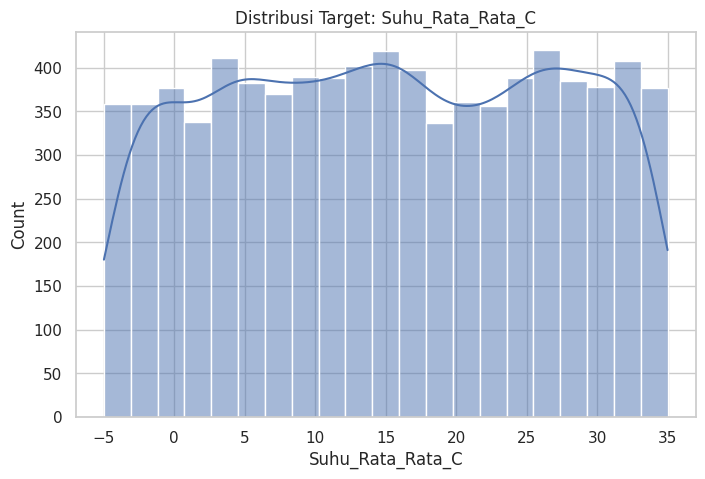

Ringkasan Target:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Suhu_Rata_Rata_C,8000.0,15.20668,11.490611,-4.99,-4.5601,-2.88,5.3775,15.14,25.34,32.99,34.6301,35.0


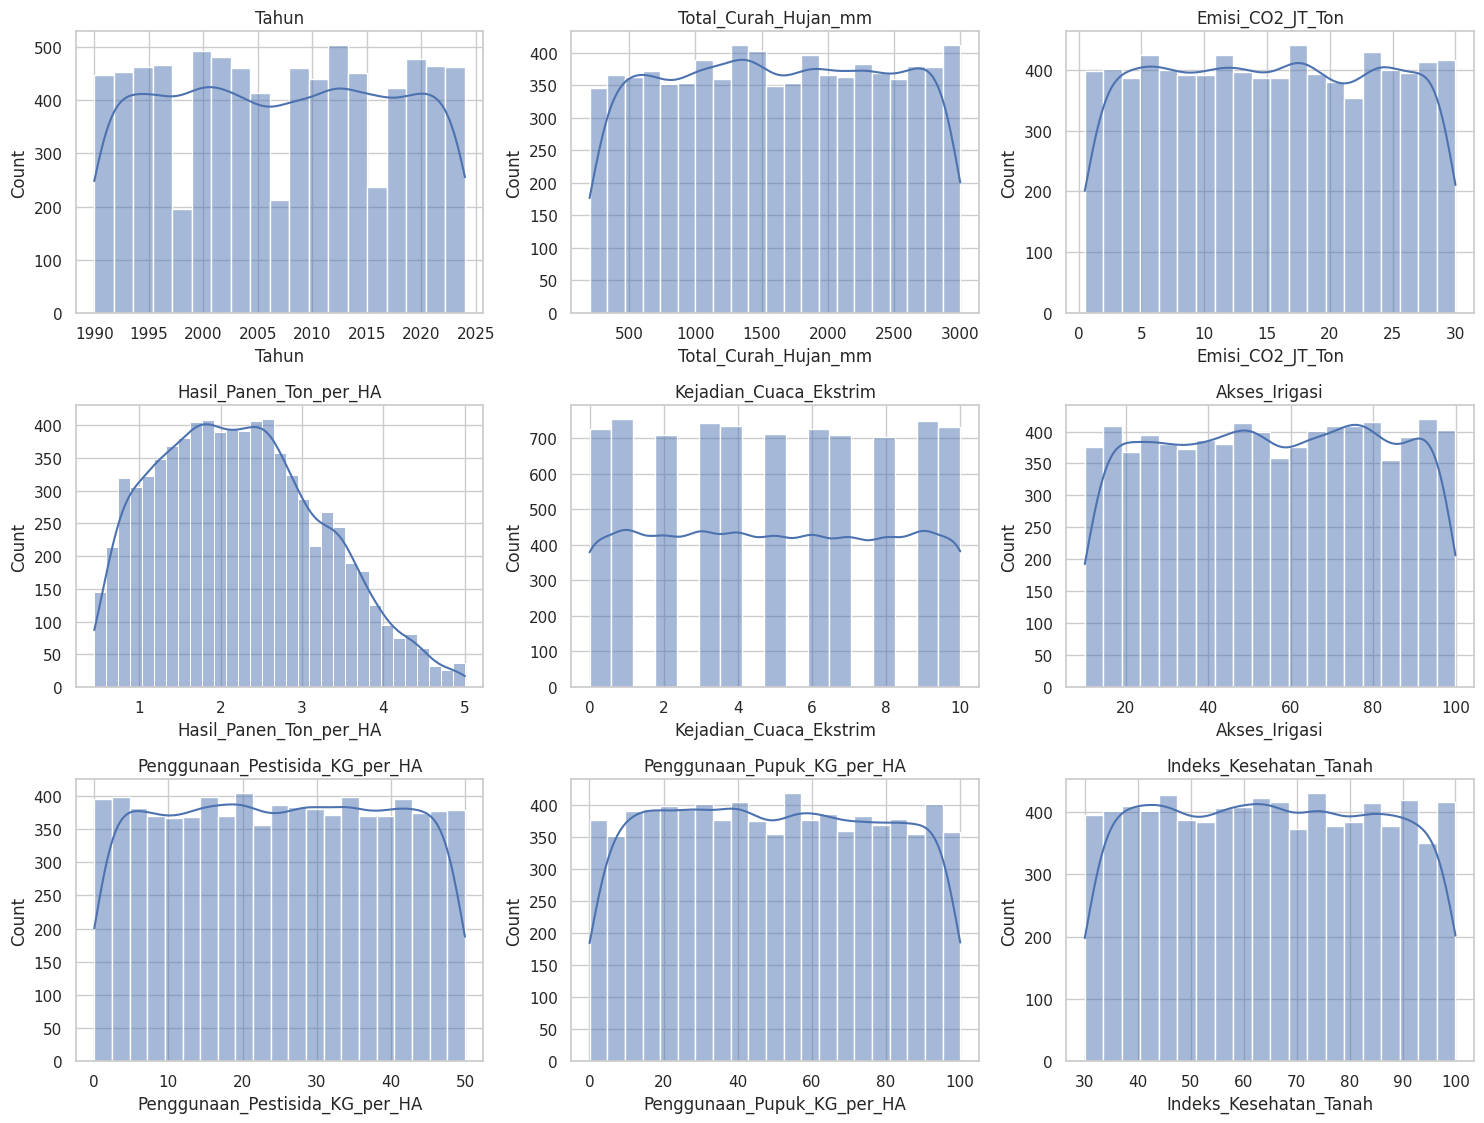

In [ ]:
TARGET = 'Suhu_Rata_Rata_C'
ID_COL = 'ID'
num_cols = [c for c in train_df.select_dtypes(include=['int64','float64']).columns if c not in [ID_COL, TARGET]]
cat_cols = train_df.select_dtypes(include='object').columns.tolist()

# Style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Distribusi Target
fig, ax = plt.subplots()
sns.histplot(train_df[TARGET], kde=True, ax=ax)
ax.set_title(f"Distribusi Target: {TARGET}")
ax.set_xlabel(TARGET)
plt.show()

print("Ringkasan Target:")
display(train_df[TARGET].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).to_frame().T)

# Distribusi Fitur Numerik (Histogram + KDE)
n = len(num_cols)
cols = 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3.8))
axes = axes.ravel()

for i, c in enumerate(num_cols):
    sns.histplot(train_df[c], kde=True, ax=axes[i])
    axes[i].set_title(c)
for j in range(i+1, rows*cols):
    axes[j].axis('off')
plt.tight_layout(); plt.show()

### HEATMAP, SCATTER DAN BOXPLOT

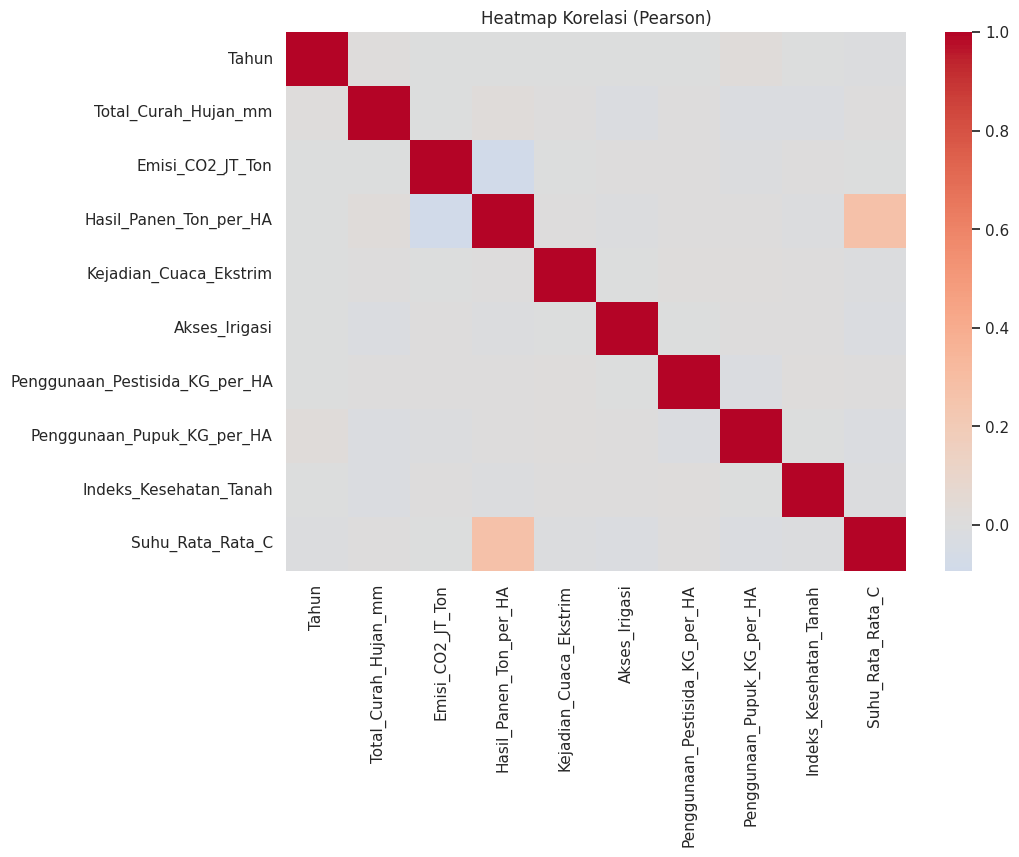

Top fitur numerik paling korelatif (|r|):


,abs_corr_with_target
Hasil_Panen_Ton_per_HA,0.267940
Penggunaan_Pupuk_KG_per_HA,0.020567
Akses_Irigasi,0.017453
Kejadian_Cuaca_Ekstrim,0.012006
Indeks_Kesehatan_Tanah,0.010886
Tahun,0.008861
Total_Curah_Hujan_mm,0.008695
Penggunaan_Pestisida_KG_per_HA,0.005331
Emisi_CO2_JT_Ton,0.001245


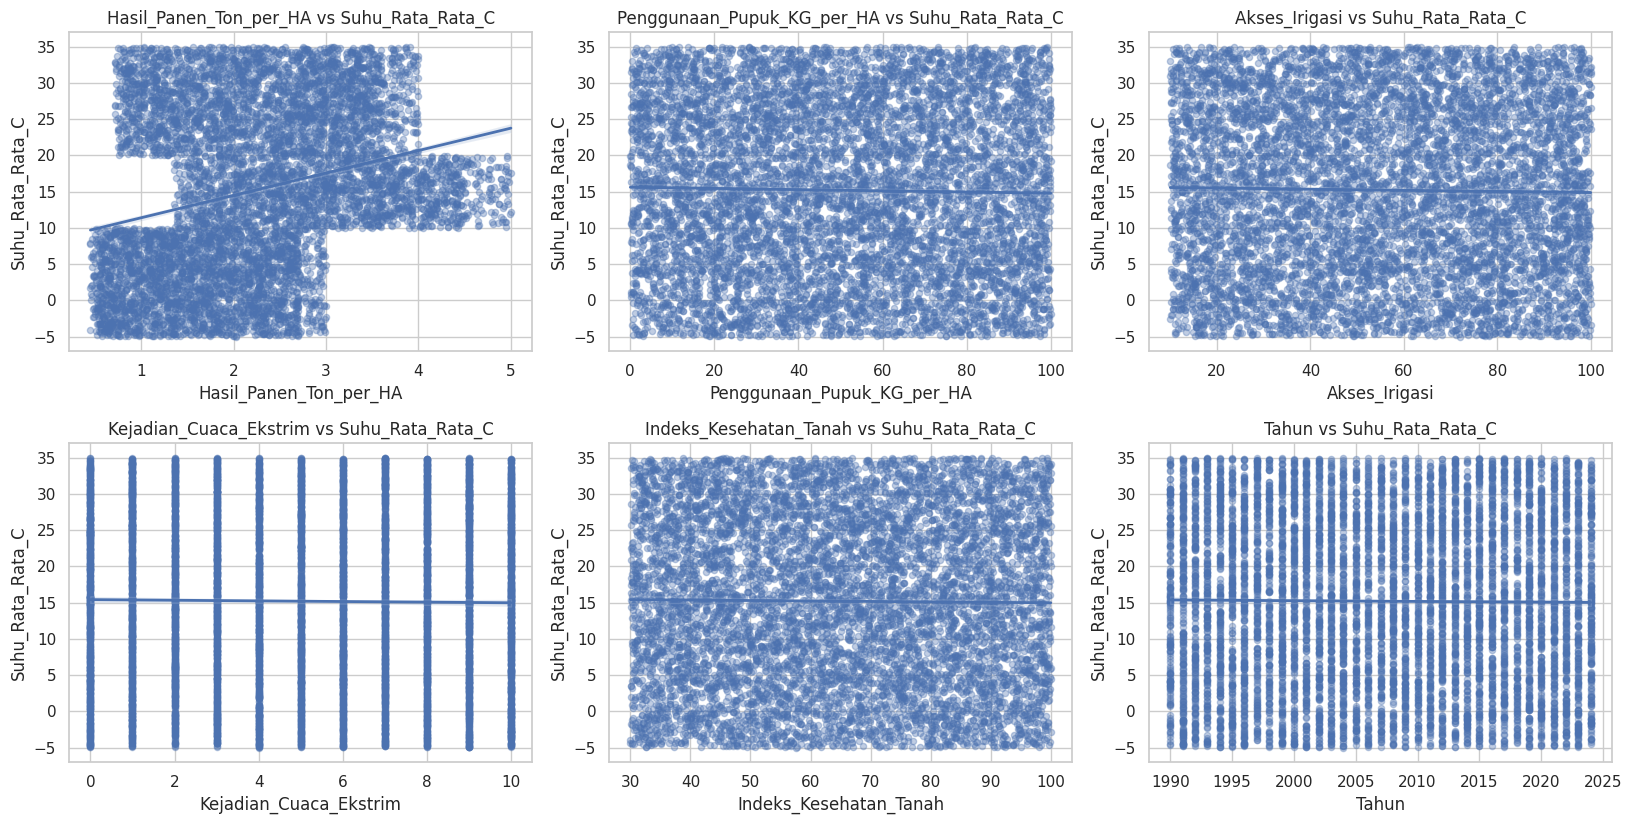

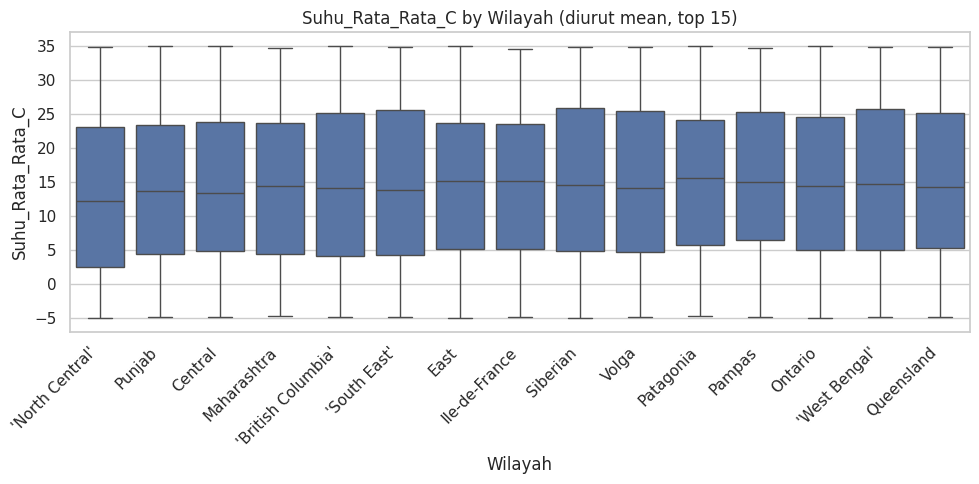

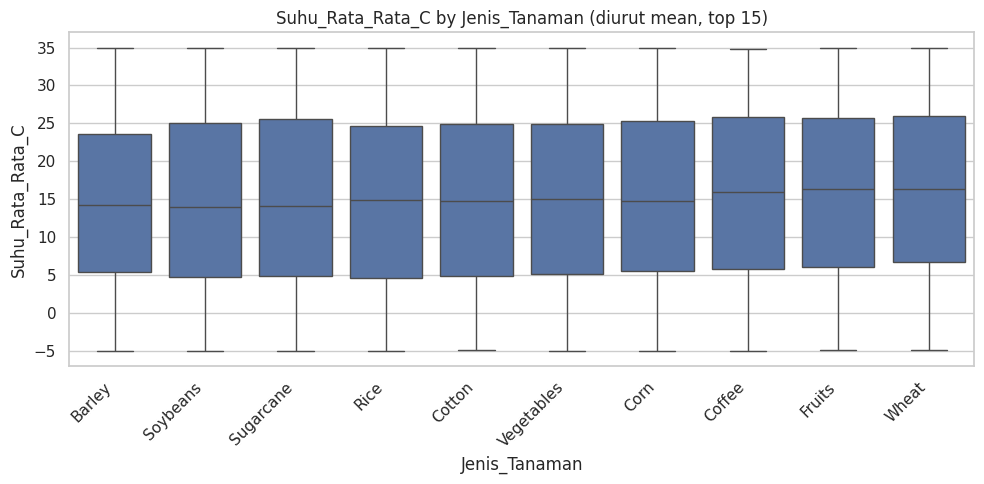

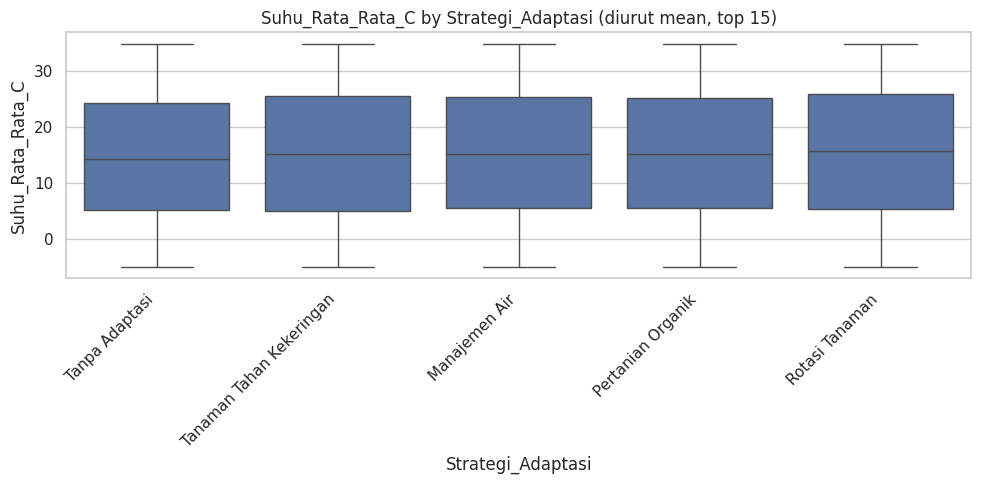

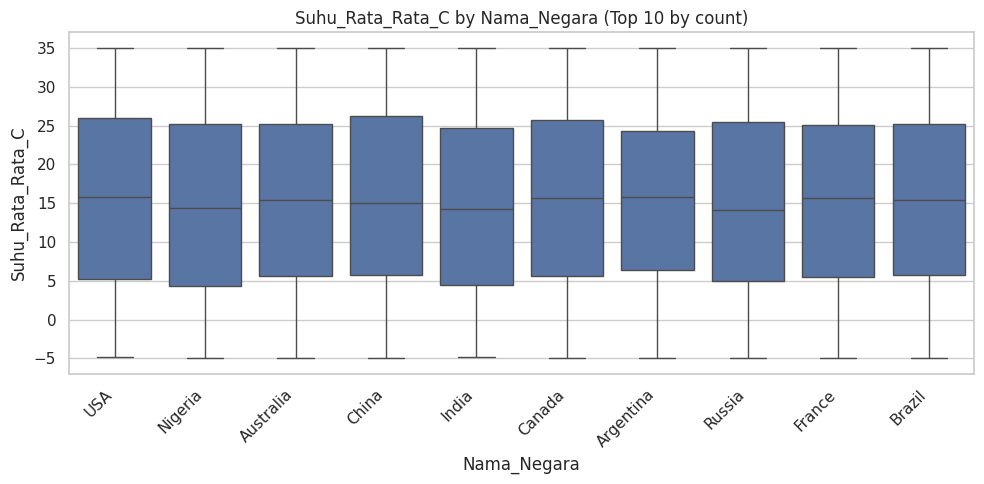

In [ ]:
# Heatmap korelasi numerik (Pearson)
corr = train_df[num_cols + [TARGET]].corr(method='pearson')
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap Korelasi (Pearson)")
plt.show()

# Top 10 fitur numerik paling korelatif dengan TARGET (absolut)
corr_target = corr[TARGET].drop(TARGET).abs().sort_values(ascending=False)
print("Top fitur numerik paling korelatif (|r|):")
display(corr_target.to_frame('abs_corr_with_target').head(10))

#  Scatter/Regplot: 6 fitur numerik teratas vs TARGET
top6 = corr_target.head(6).index.tolist()
cols = 3; rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*5.5, rows*4.2))
axes = axes.ravel()
for i, c in enumerate(top6):
    sns.regplot(x=train_df[c], y=train_df[TARGET], scatter_kws={'alpha':0.35, 's':20}, line_kws={'linewidth':2}, ax=axes[i])
    axes[i].set_xlabel(c); axes[i].set_ylabel(TARGET); axes[i].set_title(f"{c} vs {TARGET}")
plt.tight_layout(); plt.show()


# Boxplot TARGET per Kategori Utama(Wilayah, Jenis_Tanaman, Strategi_Adaptasi) berdasarkan mean TARGET
def ordered_boxplot(cat_col, top_n=15):
    order = train_df.groupby(cat_col)[TARGET].mean().sort_values().index[:top_n]
    plt.figure(figsize=(10,5))
    sns.boxplot(data=train_df, x=cat_col, y=TARGET, order=order, showfliers=False)
    plt.title(f"{TARGET} by {cat_col} (diurut mean, top {top_n})")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

for cat in ['Wilayah','Jenis_Tanaman','Strategi_Adaptasi']:
    if cat in cat_cols:
        ordered_boxplot(cat, top_n=15)

# 10 negara teratas berdasarkan jumlah sampel
top_countries = train_df['Nama_Negara'].value_counts().head(10).index
plt.figure(figsize=(10,5))
sns.boxplot(data=train_df[train_df['Nama_Negara'].isin(top_countries)],
            x='Nama_Negara', y=TARGET, order=top_countries, showfliers=False)
plt.title(f"{TARGET} by Nama_Negara (Top 10 by count)")
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

### TREN GRAFIK TARGET

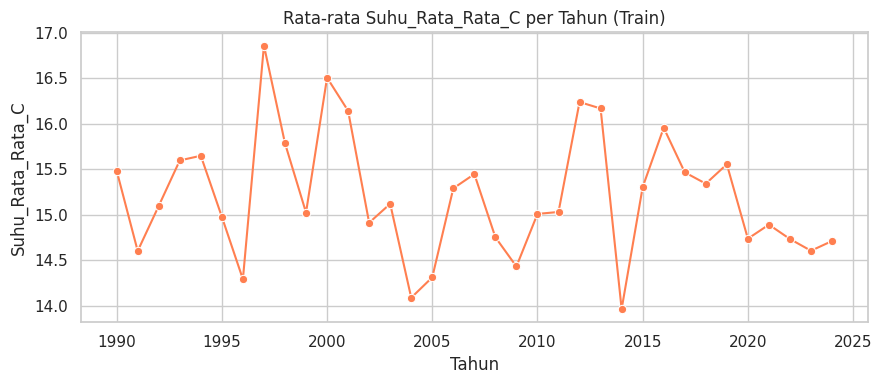

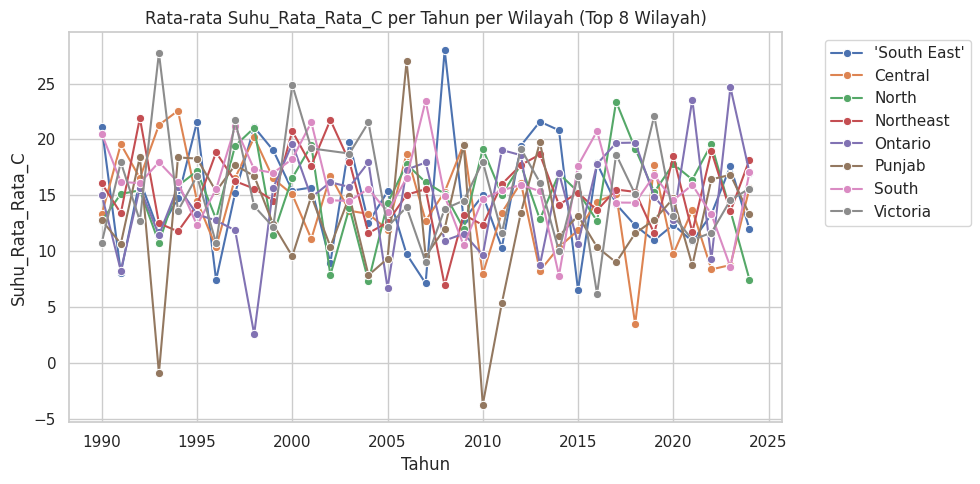

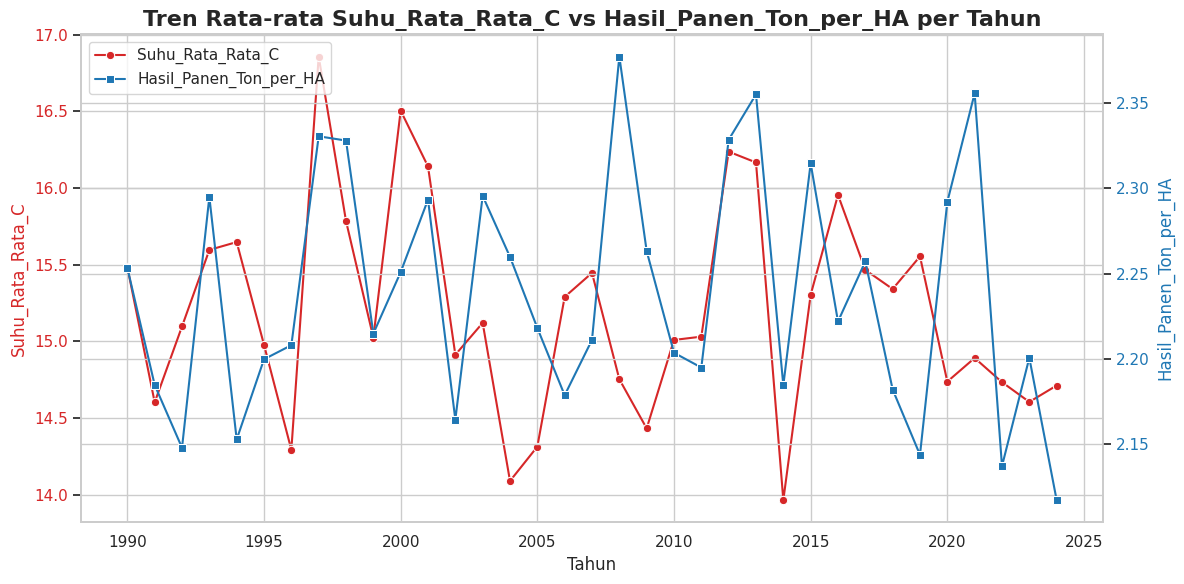

In [ ]:
# Mendefinisikan variabel-variabel kunci
TARGET = 'Suhu_Rata_Rata_C'
VAR_HASIL_PANEN = 'Hasil_Panen_Ton_per_HA'

# Memeriksa apakah data dan kolom yang diperlukan ada
if (not train_df.empty and
    TARGET in train_df.columns and
    VAR_HASIL_PANEN in train_df.columns):

    # Tren Waktu TARGET
    ts = train_df.groupby('Tahun')[TARGET].mean().reset_index()
    plt.figure(figsize=(9, 4))
    sns.lineplot(data=ts, x='Tahun', y=TARGET, marker='o', color='coral')
    plt.title(f"Rata-rata {TARGET} per Tahun (Train)")
    plt.tight_layout()
    plt.show()

    # Ambil 8 wilayah dengan data terbanyak
    wilayah_top = train_df['Wilayah'].value_counts().head(8).index
    ts_w = (train_df[train_df['Wilayah'].isin(wilayah_top)]
            .groupby(['Tahun', 'Wilayah'])[TARGET].mean().reset_index())

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=ts_w, x='Tahun', y=TARGET, hue='Wilayah', marker='o')
    plt.title(f"Rata-rata {TARGET} per Tahun per Wilayah (Top 8 Wilayah)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Pindah legenda
    plt.tight_layout()
    plt.show()

    # Menghitung rata-rata kedua variabel per tahun
    ts_dual = train_df.groupby('Tahun')[[TARGET, VAR_HASIL_PANEN]].mean().reset_index()

    # Membuat plot dengan dua sumbu Y (twin axis)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Sumbu Y pertama (kiri) untuk Suhu
    color_suhu = 'tab:red'
    ax1.set_xlabel('Tahun', fontsize=12)
    ax1.set_ylabel(TARGET, color=color_suhu, fontsize=12)
    line1 = sns.lineplot(data=ts_dual, x='Tahun', y=TARGET, ax=ax1, color=color_suhu, marker='o', label=TARGET)
    ax1.tick_params(axis='y', labelcolor=color_suhu)

    # Membuat sumbu Y kedua (kanan) yang berbagi sumbu X
    ax2 = ax1.twinx()
    color_panen = 'tab:blue'
    ax2.set_ylabel(VAR_HASIL_PANEN, color=color_panen, fontsize=12)
    line2 = sns.lineplot(data=ts_dual, x='Tahun', y=VAR_HASIL_PANEN, ax=ax2, color=color_panen, marker='s', label=VAR_HASIL_PANEN)
    ax2.tick_params(axis='y', labelcolor=color_panen)

    # Menambahkan judul
    plt.title(f"Tren Rata-rata {TARGET} vs {VAR_HASIL_PANEN} per Tahun", fontsize=16, fontweight='bold')

    # Menambahkan legenda gabungan
    # Kita ambil label dari kedua plot dan gabungkan
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # Hapus legenda otomatis dari ax1 karena sudah digabung di ax2
    if ax1.get_legend() is not None:
        ax1.get_legend().remove()

    fig.tight_layout() # Penting untuk layout twin axis
    plt.show()


else:
    # Penanganan error jika data atau kolom tidak ada
    if train_df.empty:
        print("\nDataFrame kosong. Analisis dibatalkan.")
    else:
        missing_cols = []
        if TARGET not in train_df.columns:
            missing_cols.append(TARGET)
        if VAR_HASIL_PANEN not in train_df.columns:
            missing_cols.append(VAR_HASIL_PANEN)


## OUTLIER


Analisis untuk: Total_Curah_Hujan_mm
Quantiles (train): {0.001: 203.645, 0.01: 229.59, 0.99: 2976.346, 0.999: 2997.9084000000007}


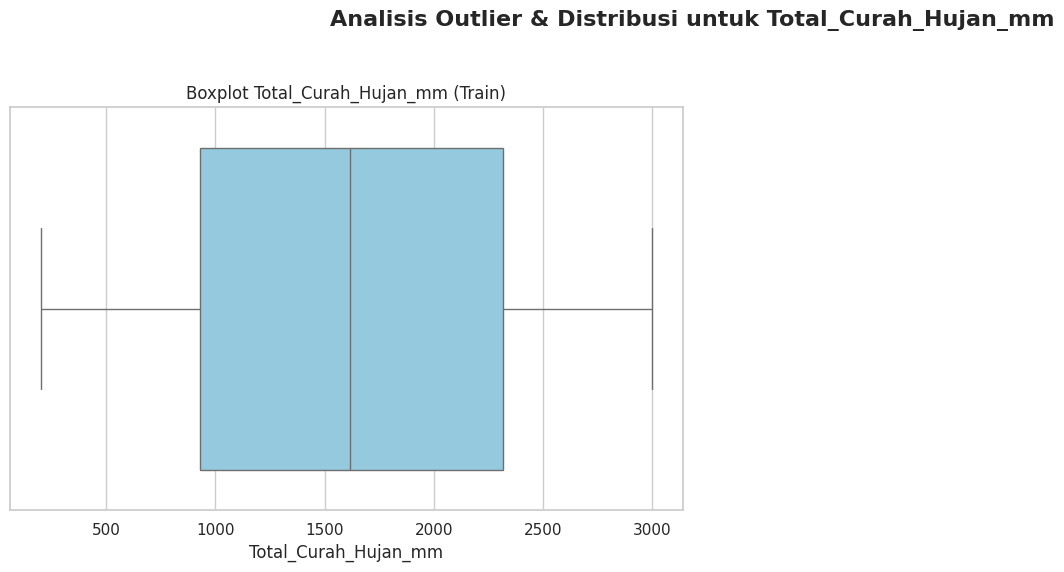


Analisis untuk: Emisi_CO2_JT_Ton
Quantiles (train): {0.001: 0.52, 0.01: 0.77, 0.99: 29.73, 0.999: 29.97}


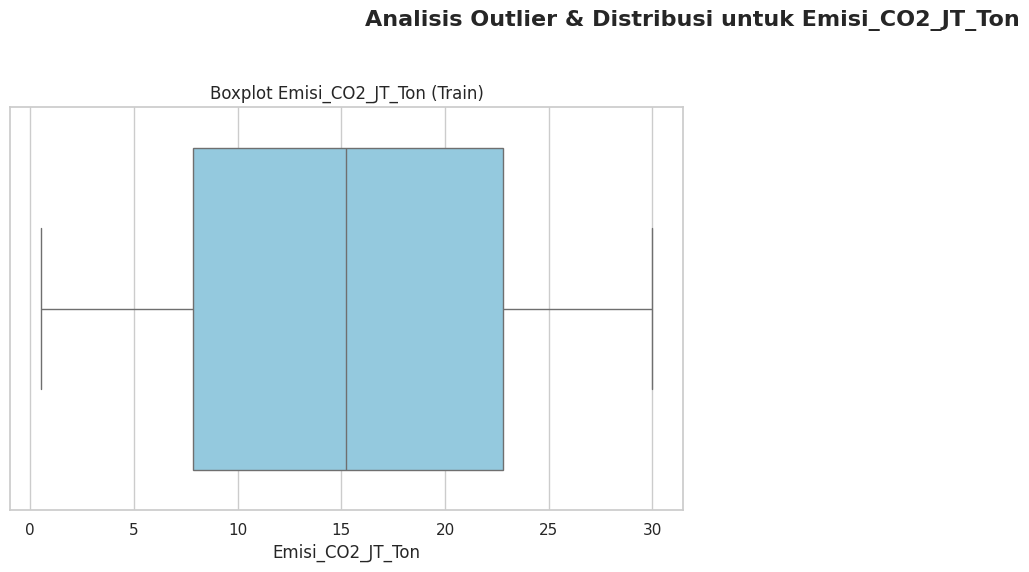


Analisis untuk: Hasil_Panen_Ton_per_HA
Quantiles (train): {0.001: 0.466191, 0.01: 0.549, 0.99: 4.63, 0.999: 4.962010000000009}


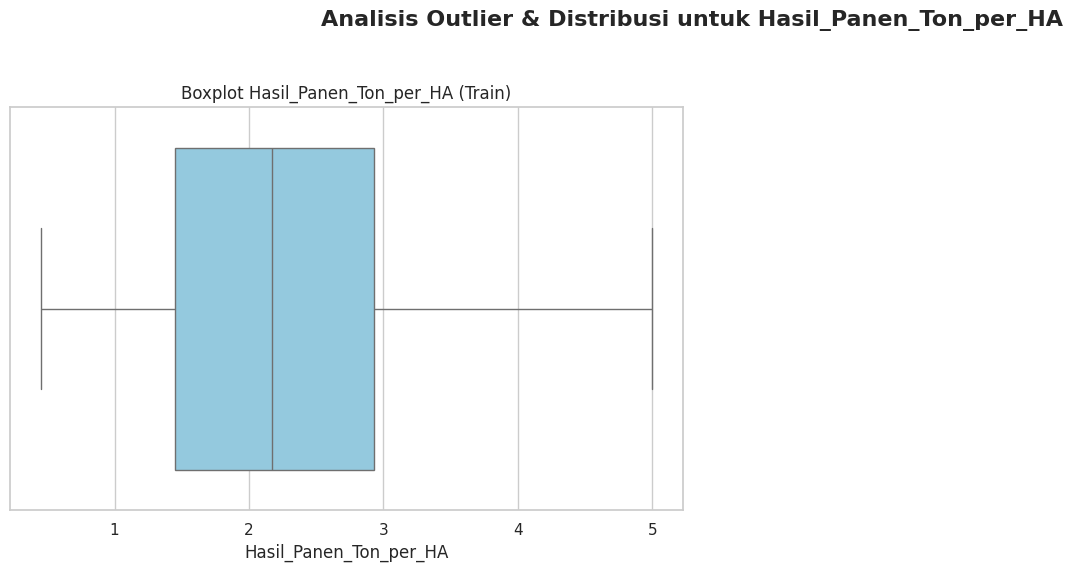


Analisis untuk: Kejadian_Cuaca_Ekstrim
Quantiles (train): {0.001: 0.0, 0.01: 0.0, 0.99: 10.0, 0.999: 10.0}


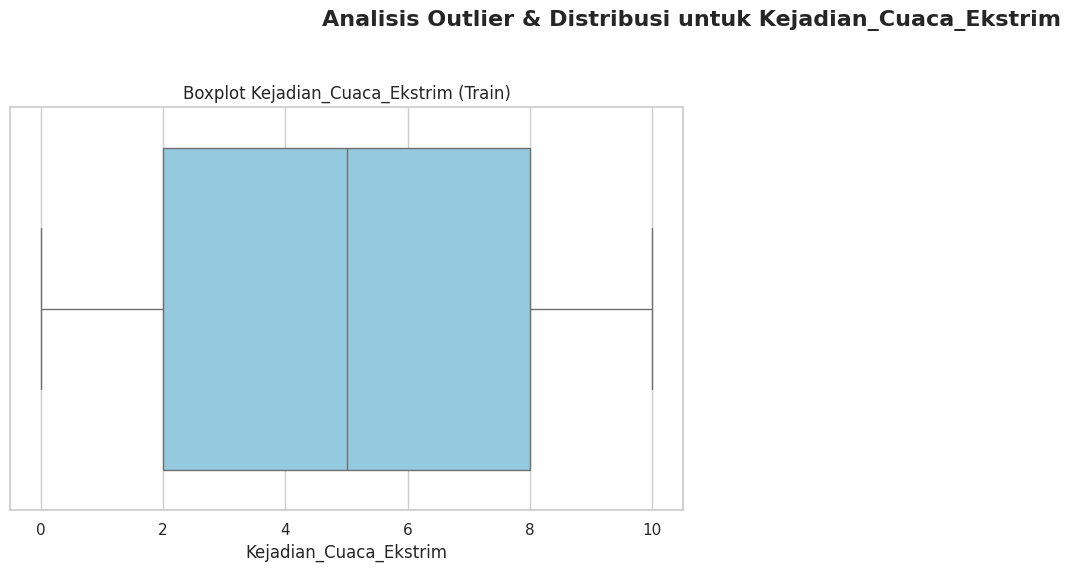


Analisis untuk: Akses_Irigasi
Quantiles (train): {0.001: 10.07, 0.01: 10.9518, 0.99: 98.95, 0.999: 99.91546000000002}


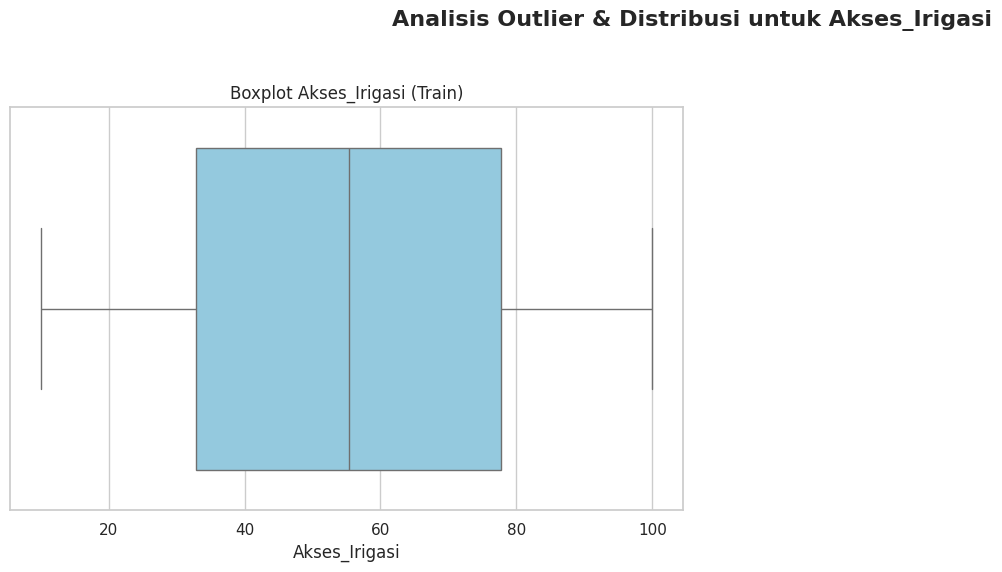


Analisis untuk: Penggunaan_Pestisida_KG_per_HA
Quantiles (train): {0.001: 0.07, 0.01: 0.51, 0.99: 49.46, 0.999: 49.90003000000003}


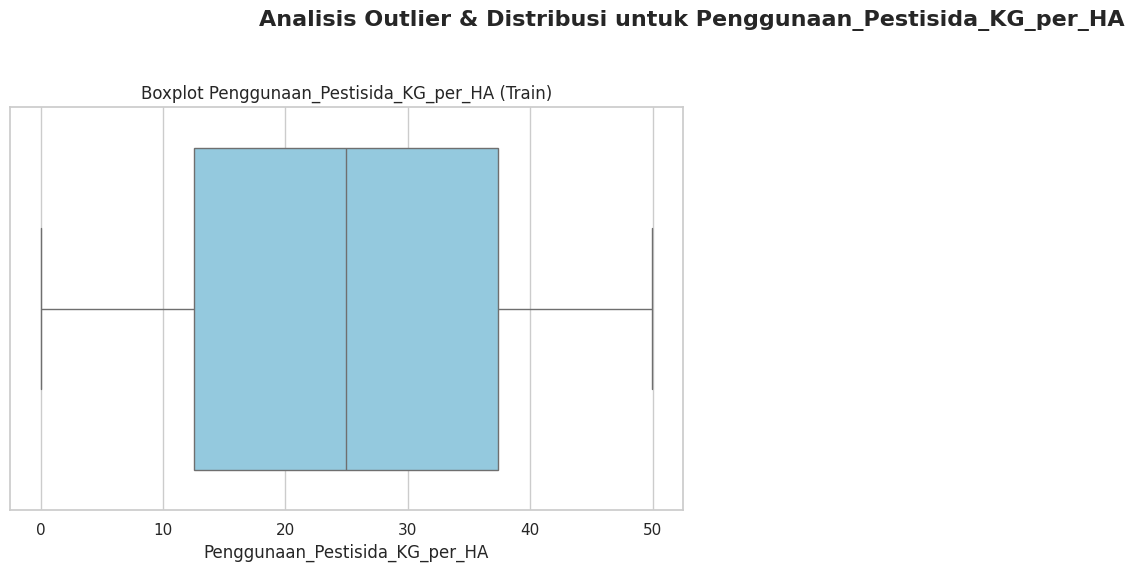


Analisis untuk: Penggunaan_Pupuk_KG_per_HA
Quantiles (train): {0.001: 0.14999, 0.01: 1.1199000000000001, 0.99: 98.87010000000001, 0.999: 99.88001000000001}


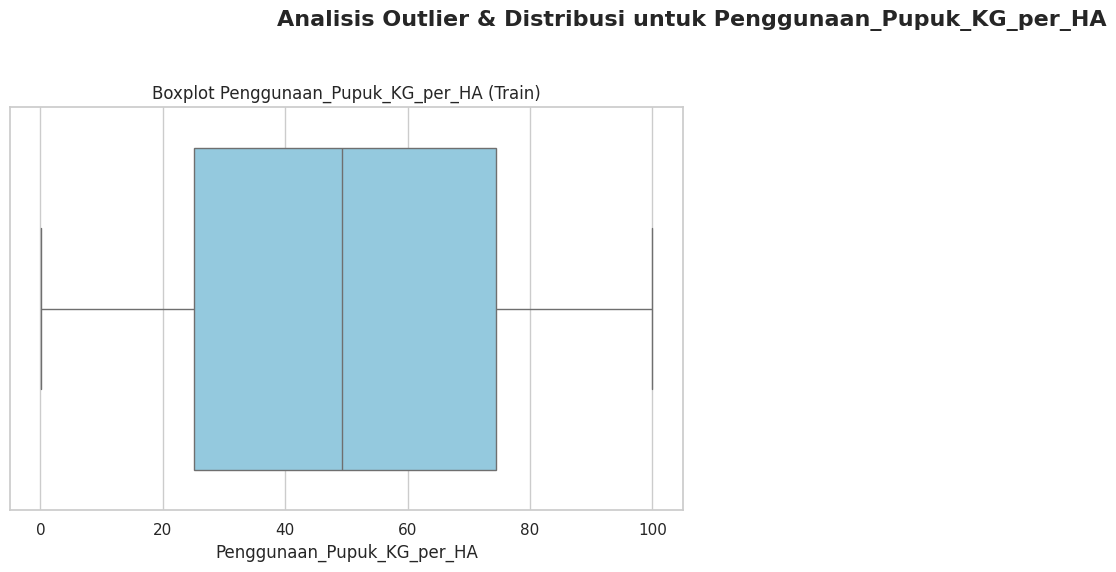


Analisis untuk: Indeks_Kesehatan_Tanah
Quantiles (train): {0.001: 30.099990000000002, 0.01: 30.71, 0.99: 99.3002, 0.999: 99.95001000000002}


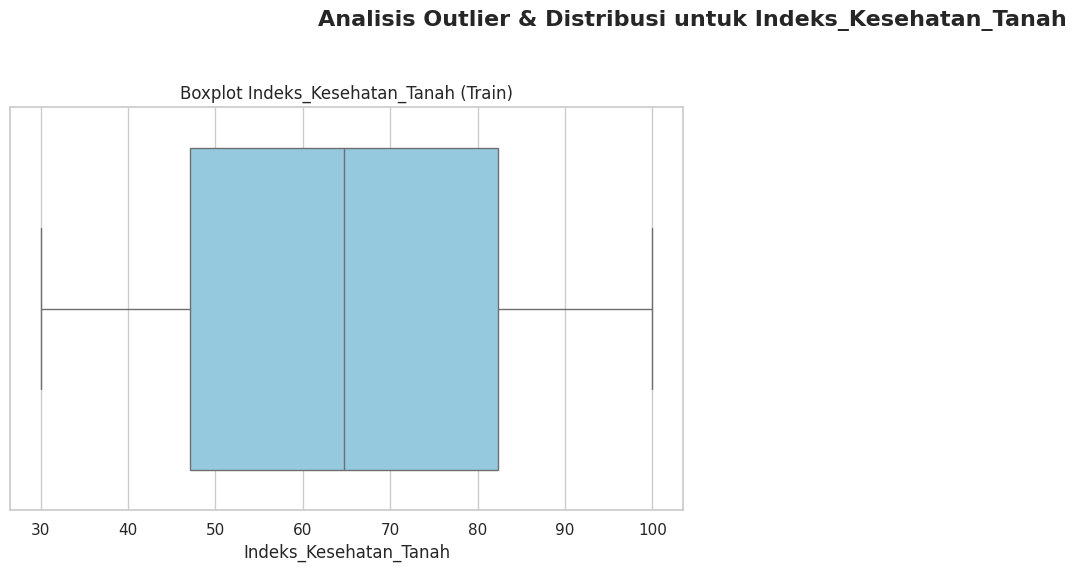


Analisis selesai.


In [ ]:
# Kolom yang akan dicek, sesuai permintaan Anda
shift_cols = ['Total_Curah_Hujan_mm', 'Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA', 'Kejadian_Cuaca_Ekstrim', 'Akses_Irigasi', 'Penggunaan_Pestisida_KG_per_HA','Penggunaan_Pupuk_KG_per_HA', 'Indeks_Kesehatan_Tanah']

# Memastikan DataFrame tidak kosong sebelum melanjutkan
if not train_df.empty:

    for c in shift_cols:
        if c in train_df.columns:
            # Menghitung quantile
            q = train_df[c].quantile([.001, .01, .99, .999]).to_dict()
            print(f"\nAnalisis untuk: {c}")
            print(f"Quantiles (train):", q)

            # Membuat figure untuk dua plot (boxplot dan histogram)
            plt.figure(figsize=(14, 6))

            # Plot 1: Boxplot (untuk cek outlier)
            plt.subplot(1, 2, 1)
            sns.boxplot(x=train_df[c], color='skyblue')
            plt.title(f"Boxplot {c} (Train)")
            plt.xlabel(c)

            # Menambahkan judul keseluruhan
            plt.suptitle(f"Analisis Outlier & Distribusi untuk {c}", fontsize=16, fontweight='bold')

            # Menyesuaikan layout dan menampilkan plot
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Memberi ruang untuk suptitle
            plt.show()

        else:
            print(f"\nPERINGATAN: Kolom '{c}' tidak ditemukan di train.csv.")
else:
    print("\nDataFrame kosong. Analisis dibatalkan.")

print("\nAnalisis selesai.")


# PREPROCESSING

Tahap pra proses data dilakukan untuk membersihkan dan mentransformasi data mentah menjadi format yang optimal untuk pemodelan.

## HANDLING MISSING VALUE

In [ ]:
# Buat salinan untuk diproses
train = train_df.copy()
test  = test_df.copy()

all_df = pd.concat([
    train.drop('Suhu_Rata_Rata_C', axis=1),
    test
], ignore_index=True)

# Imputasi missing value
num_missing_cols = ['Total_Curah_Hujan_mm', 'Hasil_Panen_Ton_per_HA', 'Akses_Irigasi']
cat_missing_cols = ['Jenis_Tanaman']

# Imputasi numerik: mean
for col in num_missing_cols:
    if col in all_df.columns:
        mean_val = all_df[col].mean()
        all_df[col] = all_df[col].fillna(mean_val)
        if col in test.columns:
            test[col]  = test[col].fillna(mean_val)

# Imputasi kategorikal: mode dari TRAIN
for col in cat_missing_cols:
    if col in train.columns:
        mode_val = train[col].mode(dropna=True)
        mode_val = mode_val.iloc[0] if len(mode_val) > 0 else "Unknown"
        all_df[col] = all_df[col].fillna(mode_val)
        if col in test.columns:
            test[col]  = test[col].fillna(mode_val)

## ENCODING KATEGORIKAL


In [ ]:
# Encoding kategorik
categorical_features = ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Strategi_Adaptasi']
le = LabelEncoder()
for col in categorical_features:
    all_df[col] = le.fit_transform(all_df[col])


# MODEL BASELINE


**Skrip Perbandingan Model (Baseline Eksperimen):**
Tujuan: Menjalankan LGBM, XGBoost, dan CatBoost pada set fitur untuk membandingkan skor MAPE baseline mereka.

1.  Muat Data.
2.  Tentukan 3 model (LGBM, XGB, CatBoost) dengan parameter default.
3.  Jalankan 10-fold GroupKFold untuk SETIAP model.
4.  Cetak skor OOF MAPE untuk setiap model.
5.  Simpan 3 file submisi terpisah.

## PERBANDINGAN MODEL LGBM, XGBOOOST DAN CAT BOOST

In [ ]:

X = all_df.iloc[:len(train_df)]
y = train_df['Suhu_Rata_Rata_C']
X_test_final = all_df.iloc[len(train_df):]

features = [col for col in all_df.columns if col not in ['ID']]
groups = X['Tahun']
cat_features_names = ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Strategi_Adaptasi']


# Perbandingan Model
N_SPLITS_REG = 10
gkf = GroupKFold(n_splits=N_SPLITS_REG)

# Tentukan model-model yang akan diuji
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(
        objective='mape', metric='mape', n_estimators=2000,
        n_jobs=-1, verbose=-1, seed=42
    ),
    'XGBoost': xgb.XGBRegressor(
        objective='reg:squarederror', eval_metric='mape', n_estimators=2000,
        n_jobs=-1, random_state=42, early_stopping_rounds=100
    ),
    'CatBoost': cat.CatBoostRegressor(
        loss_function='MAPE', n_estimators=2000,
        random_seed=42, verbose=0, early_stopping_rounds=100,
        allow_writing_files=False
    )
}

# Simpan hasil
oof_scores = {}

# Loop untuk setiap model
for model_name, model in models_to_test.items():
    print(f"\nMenguji Model: {model_name}")

    oof_preds = np.zeros(X.shape[0])
    test_preds_list = []

    for fold, (train_index, val_index) in enumerate(gkf.split(X, y, groups=groups), 1):
        print(f"Fold {fold}/{N_SPLITS_REG}", end="")
        X_train, X_val = X.iloc[train_index][features], X.iloc[val_index][features]
        y_train_asli, y_val_asli = y.iloc[train_index], y.iloc[val_index]

        # Tentukan parameter fit
        fit_params = {
            'eval_set': [(X_val, y_val_asli)],
        }

        if model_name == 'LightGBM':
            fit_params['callbacks'] = [lgb.early_stopping(100, verbose=False)]
            fit_params['categorical_feature'] = cat_features_names
            model.fit(X_train, y_train_asli, **fit_params)
            best_iter = getattr(model, 'best_iteration_', 2000)
            val_preds = model.predict(X_val, num_iteration=best_iter)
            preds_fold = model.predict(X_test_final[features], num_iteration=best_iter)

        elif model_name == 'XGBoost':
            # XGBoost tidak menggunakan 'categorical_feature' di fit
            model.fit(X_train, y_train_asli, **fit_params, verbose=False)
            val_preds = model.predict(X_val)
            preds_fold = model.predict(X_test_final[features])

        elif model_name == 'CatBoost':
            fit_params['cat_features'] = cat_features_names
            model.fit(X_train, y_train_asli, **fit_params)
            val_preds = model.predict(X_val)
            preds_fold = model.predict(X_test_final[features])

        print("Selesai")
        oof_preds[val_index] = np.clip(val_preds, 0.0, None)
        test_preds_list.append(np.clip(preds_fold, 0.0, None))
        gc.collect()

    # Hitung skor OOF untuk model ini
    skor_oof_model = mean_absolute_percentage_error(y, oof_preds)
    oof_scores[model_name] = skor_oof_model
    print(f"Skor OOF {model_name}: {skor_oof_model:.5f}")

    # Buat submission file untuk model ini
    submission_pred_final = np.mean(np.vstack(test_preds_list), axis=0)
    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'Suhu_Rata_Rata_C': submission_pred_final
    })
    submission_filename = f'submission_baseline_{model_name}.csv'
    submission_df.to_csv(submission_filename, index=False)
    print(f"File submisi disimpan sebagai: {submission_filename}")

print("\n[Perbandingan Model Selesai]")
print("Skor OOF (Mean Absolute Percentage Error):")
for model_name, score in oof_scores.items():
    print(f"- {model_name}: {score:.5f}")



--- [Tahap 5: Memulai Perbandingan Model (Default Params)] ---

--- Menguji Model: LightGBM ---
--- Fold 1/10 --- ... Selesai
--- Fold 2/10 --- ... Selesai
--- Fold 3/10 --- ... Selesai
--- Fold 4/10 --- ... Selesai
--- Fold 5/10 --- ... Selesai
--- Fold 6/10 --- ... Selesai
--- Fold 7/10 --- ... Selesai
--- Fold 8/10 --- ... Selesai
--- Fold 9/10 --- ... Selesai
--- Fold 10/10 --- ... Selesai
----------------------------------------
Skor OOF LightGBM: 1.02128
----------------------------------------
File submisi disimpan sebagai: submission_baseline_LightGBM.csv

--- Menguji Model: XGBoost ---
--- Fold 1/10 --- ... Selesai
--- Fold 2/10 --- ... Selesai
--- Fold 3/10 --- ... Selesai
--- Fold 4/10 --- ... Selesai
--- Fold 5/10 --- ... Selesai
--- Fold 6/10 --- ... Selesai
--- Fold 7/10 --- ... Selesai
--- Fold 8/10 --- ... Selesai
--- Fold 9/10 --- ... Selesai
--- Fold 10/10 --- ... Selesai
----------------------------------------
Skor OOF XGBoost: 4.33913
-----------------------------

# MODEL LGBM

Model **LightGBM** dipilih bukan hanya karena skornya terendah, tetapi karena arsitekturnya terbukti paling robust dan stabil terhadap tantangan inti dari dataset ini, yaitu metrik MAPE yang sensitif yang menjadi rintangan dalam lomba ini.


In [ ]:
# Modifikasi pelatihan baseline
print("\nModifikasi pelatihan baseline")

X_test = X_test_final[features]

# Gunakan parameter default, HANYA tentukan objective & seed
baseline_params = {
    'objective': 'mape',
    'metric': 'mape',
    'n_estimators': 2000, # Jumlah estimator default yang wajar
    'n_jobs': -1,
    'verbose': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

N_SPLITS_REG = 10
_gkf = GroupKFold(n_splits=N_SPLITS_REG)

test_preds_list = [] # Prediksi test
oof_preds = np.zeros(X.shape[0]) # Prediksi OOF

for fold, (train_index, val_index) in enumerate(_gkf.split(X, y, groups=groups), 1):
    print(f"Fold {fold}/{N_SPLITS_REG}")
    X_train, X_val = X.iloc[train_index][features], X.iloc[val_index][features]
    y_train_asli, y_val_asli = y.iloc[train_index], y.iloc[val_index]

    # Sesuai penjelasan_baseline.md
    model = lgb.LGBMRegressor(**baseline_params)
    model.fit(
        X_train, y_train_asli,
        eval_set=[(X_val, y_val_asli)],
        eval_metric='mape',
        callbacks=[lgb.early_stopping(100, verbose=False)],
        categorical_feature=cat_features_names
    )

    best_iter = getattr(model, 'best_iteration_', baseline_params['n_estimators'])

    # Sesuai penjelasan_baseline.md
    val_preds = model.predict(X_val, num_iteration=best_iter)
    oof_preds[val_index] = np.clip(val_preds, 0.0, None)

    preds_fold = model.predict(X_test, num_iteration=best_iter)
    test_preds_list.append(np.clip(preds_fold, 0.0, None))
    gc.collect()

# Finalisasi & Submission Baseline
# Dapatkan skor OOF Baseline
skor_baseline = mean_absolute_percentage_error(y, oof_preds)
print(f"Skor OOF Baseline (Fitur Penuh, Model Default): {skor_baseline:.5f}")

# Buat file submission baseline
submission_pred_final = np.mean(np.vstack(test_preds_list), axis=0)
submission_pred_final = np.clip(submission_pred_final, 0.0, None)

submission_df_base = pd.DataFrame({
    'ID': test_df['ID'],
    'Suhu_Rata_Rata_C': submission_pred_final
})
submission_filename_base = 'submission_strong_baseline.csv'
submission_df_base.to_csv(submission_filename_base, index=False)
print(f"\nFile submisi Strong Baseline disimpan sebagai: {submission_filename_base}")



Modifikasi pelatihan baseline
--- Fold 1/10 ---
--- Fold 2/10 ---
--- Fold 3/10 ---
--- Fold 4/10 ---
--- Fold 5/10 ---
--- Fold 6/10 ---
--- Fold 7/10 ---
--- Fold 8/10 ---
--- Fold 9/10 ---
--- Fold 10/10 ---
----------------------------------------
Skor OOF Baseline (Fitur Penuh, Model Default): 1.02128
----------------------------------------

File submisi Strong Baseline disimpan sebagai: submission_strong_baseline.csv


# TUNING MODEL LGBM

LightGBM terpilih dari seleksi model ke optimasi mendalam. Tahap ini terdiri dari dua yaitu (1) Stabilisasi Metrik dan Tuning Simultan dengan Optuna, dan (2) Kalibrasi Distribusi Post-Processing.


## FEATURE ENGINEERING

In [ ]:
# Buat salinan untuk diproses
train = train_df.copy()
test  = test_df.copy()

all_df = pd.concat([
    train.drop('Suhu_Rata_Rata_C', axis=1),
    test
], ignore_index=True)

# Imputasi
num_missing_cols = ['Total_Curah_Hujan_mm', 'Hasil_Panen_Ton_per_HA', 'Akses_Irigasi']
for col in num_missing_cols:
    all_df[col] = all_df[col].fillna(all_df[col].median())
cat_missing_cols = ['Jenis_Tanaman']
for col in cat_missing_cols:
    all_df[col] = all_df[col].fillna(all_df[col].mode()[0])
# Encoding
categorical_features = ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Strategi_Adaptasi']
le = LabelEncoder()
for col in categorical_features:
    all_df[col] = le.fit_transform(all_df[col])
# Fitur Agregat Statis
numeric_features = [
    'Total_Curah_Hujan_mm', 'Emisi_CO2_JT_Ton', 'Hasil_Panen_Ton_per_HA',
    'Kejadian_Cuaca_Ekstrim', 'Akses_Irigasi', 'Penggunaan_Pestisida_KG_per_HA',
    'Penggunaan_Pupuk_KG_per_HA', 'Indeks_Kesehatan_Tanah'
]
group_cols_agg = ['Nama_Negara', 'Wilayah']
for group_col in group_cols_agg:
    for col in numeric_features:
        for stat in ['mean', 'std', 'max', 'min']:
            stat_name = f'{col}agg_by{group_col}_{stat}'
            grouped = all_df.groupby(group_col)[col].transform(stat)
            all_df[stat_name] = grouped

# Fitur rasio
all_df['Pupuk_per_Pestisida'] = all_df['Penggunaan_Pupuk_KG_per_HA'] / (all_df['Penggunaan_Pestisida_KG_per_HA'] + 1e-6)
all_df['Pupuk_per_HasilPanen'] = all_df['Penggunaan_Pupuk_KG_per_HA'] / (all_df['Hasil_Panen_Ton_per_HA'] + 1e-6)
all_df['Pestisida_per_HasilPanen'] = all_df['Penggunaan_Pestisida_KG_per_HA'] / (all_df['Hasil_Panen_Ton_per_HA'] + 1e-6)
all_df['CurahHujan_per_Irigasi'] = all_df['Total_Curah_Hujan_mm'] / (all_df['Akses_Irigasi'] + 1e-6)
all_df['Emisi_per_HasilPanen'] = all_df['Emisi_CO2_JT_Ton'] / (all_df['Hasil_Panen_Ton_per_HA'] + 1e-6)


## MODEL OPTIMALISASI

In [ ]:
# BUAT FITUR BANTUAN (PROB_IS_ZERO)
y_is_zero = (y <= 0.01).astype(int)
features_clf = [col for col in all_df.columns if col not in ['ID']]
X_clf = all_df[features_clf]
X_train_clf = X_clf.iloc[:len(train_df)]
X_test_clf = X_clf.iloc[len(train_df):]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clf)
X_test_scaled = scaler.transform(X_test_clf)

N_SPLITS_CLF = 10
gkf_clf = GroupKFold(n_splits=N_SPLITS_CLF)
groups_clf = X_train_clf['Tahun']

oof_prob_is_zero = np.zeros(X_train_scaled.shape[0])
test_prob_is_zero = np.zeros(X_test_scaled.shape[0])

model_clf = LogisticRegression(solver='liblinear', random_state=42)

for fold, (train_index, val_index) in enumerate(gkf_clf.split(X_train_scaled, y_is_zero, groups=groups_clf)):
    X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train = y_is_zero.iloc[train_index]
    model_clf.fit(X_train, y_train)
    oof_prob_is_zero[val_index] = model_clf.predict_proba(X_val)[:, 1]
    test_prob_is_zero += model_clf.predict_proba(X_test_scaled)[:, 1] / N_SPLITS_CLF

all_df['prob_is_zero'] = np.concatenate([oof_prob_is_zero, test_prob_is_zero])



# Pisahkan Data & Tentukan Fitur
X = all_df.iloc[:len(train_df)]
X_test_final = all_df.iloc[len(train_df):]

features = [col for col in all_df.columns if col not in ['ID']]
groups = X['Tahun']
cat_features_names = ['Nama_Negara', 'Wilayah', 'Jenis_Tanaman', 'Strategi_Adaptasi']

#  Fungsi Objective Optuna
N_SPLITS_REG = 10
N_TRIALS_REG = 75

def objective_reg(trial):

    # Tuning Nilai Klip
    clip_value = trial.suggest_float('clip_value', 0.01, 0.5)

    params = {
        'objective': 'mape', 'metric': 'mape',
        'n_estimators': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        # Tuning Parameter Model
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10.0),
        'verbose': -1, 'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt',
    }

    gkf = GroupKFold(n_splits=N_SPLITS_REG)
    oof_predictions = np.zeros(X.shape[0])

    for fold, (train_index, val_index) in enumerate(gkf.split(X, y, groups=groups)):
        X_train, X_val = X.iloc[train_index][features], X.iloc[val_index][features]
        y_train_asli, y_val_asli = y.iloc[train_index], y.iloc[val_index]

        # Gunakan value yang sedang di tuning
        y_train_clipped = y_train_asli.clip(lower=clip_value)

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train_clipped,
                    eval_set=[(X_val, y_val_asli.clip(lower=clip_value))],
                    eval_metric='mape',
                    callbacks=[lgb.early_stopping(100, verbose=False)],
                    categorical_feature=cat_features_names)

        val_preds = model.predict(X_val)
        val_preds_clipped = np.clip(val_preds, 0.0, None)
        oof_predictions[val_index] = val_preds_clipped
        gc.collect()

    oof_mape = mean_absolute_percentage_error(y, oof_predictions)
    return oof_mape

print(f"Memulai studi Optuna ({N_TRIALS_REG} percobaan) untuk MAPE ")
study_reg = optuna.create_study(direction='minimize')

# Enqueue parameter baseline
study_reg.enqueue_trial({
    'clip_value': 0.01,
    'learning_rate': 0.0230, 'num_leaves': 41, 'max_depth': 6,
    'min_child_samples': 91, 'feature_fraction': 0.999,
    'bagging_fraction': 0.943, 'bagging_freq': 1, 'lambda_l1': 4.439,
    'lambda_l2': 5.726
})
# Enqueue parameter baseline
study_reg.enqueue_trial({
    'clip_value': 0.0594,
    'learning_rate': 0.0438, 'num_leaves': 36, 'max_depth': 5,
    'min_child_samples': 21, 'feature_fraction': 0.999,
    'bagging_fraction': 0.655, 'bagging_freq': 1, 'lambda_l1': 7.787,
    'lambda_l2': 5.122
})

study_reg.optimize(objective_reg, n_trials=N_TRIALS_REG, show_progress_bar=True)

#  Evaluasi Akhir Optuna
print(f"Studi Optuna selesai.")
try:
    print(f"Percobaan 1 (Enqueued): {study_reg.trials[0].value:.5f}")
    print(f"Percobaan 2 (Enqueued): {study_reg.trials[1].value:.5f}")
except IndexError:
    pass
print(f"Skor OOF MAPE TERBAIK (Hasil Tuning): {study_reg.best_value:.5f}")
print("Parameter Terbaik Ditemukan:")
print(study_reg.best_params)

# Pelatihan Final & Persiapan Kalibrasi
print("\nTahap 2: Pelatihan Final & Persiapan Kalibrasi")

X_test = X_test_final[features]
best_params_reg_full = study_reg.best_params.copy()

# Ambil value terbaik dari studi
final_clip_value = best_params_reg_full.pop('clip_value')
print(f"Melatih OOF final : {final_clip_value:.4f}")

# Siapkan parameter final
best_params_reg_final = best_params_reg_full
best_params_reg_final.update({
    'objective': 'mape', 'metric': 'mape', 'boosting_type': 'gbdt',
    'n_estimators': 5000, 'n_jobs': -1, 'verbose': -1, 'seed': 42,
})

_gkf = GroupKFold(n_splits=N_SPLITS_REG)

# Variabel untuk kalibrasi
test_preds_list = [] # Prediksi test MENTAH (per fold)
oof_preds = np.zeros(X.shape[0]) # Prediksi OOF MENTAH

for fold, (train_index, val_index) in enumerate(_gkf.split(X, y, groups=groups), 1):
    print(f"Fold {fold}/{N_SPLITS_REG}")
    X_train, X_val = X.iloc[train_index][features], X.iloc[val_index][features]
    y_train_asli, y_val_asli = y.iloc[train_index], y.iloc[val_index]

    # Gunakan final_value
    y_train_clipped = y_train_asli.clip(lower=final_clip_value)

    model = lgb.LGBMRegressor(**best_params_reg_final)
    model.fit(
        X_train, y_train_clipped,
        eval_set=[(X_val, y_val_asli.clip(lower=final_clip_value))],
        eval_metric='mape',
        callbacks=[lgb.early_stopping(100, verbose=False)],
        categorical_feature=cat_features_names
    )

    best_iter = getattr(model, 'best_iteration_', best_params_reg_final['n_estimators'])

    # Simpan prediksi OOF mentah
    val_preds = model.predict(X_val, num_iteration=best_iter)
    oof_preds[val_index] = val_preds

    # Simpan prediksi test mentah
    preds_fold = model.predict(X_test, num_iteration=best_iter)
    test_preds_list.append(preds_fold)
    gc.collect()

# Finalisasi & Submission Baseline
# Dapatkan skor OOF Baseline (sebelum kalibrasi)
oof_preds_baseline = np.clip(oof_preds, 0.0, None)
skor_baseline = mean_absolute_percentage_error(y, oof_preds_baseline)
print(f"Skor OOF Baseline (Sebelum Kalibrasi): {skor_baseline:.5f}")

# Buat file submission baseline
submission_pred_base = np.mean(np.vstack(test_preds_list), axis=0)
submission_pred_final_base = np.clip(submission_pred_base, 0.0, None)

submission_df_base = pd.DataFrame({
    'ID': test_df['ID'],
    'Suhu_Rata_Rata_C': submission_pred_final_base
})
submission_filename_base = 'submission_baseline_tuned.csv'
submission_df_base.to_csv(submission_filename_base, index=False)
print(f"\nFile submisi Baseline disimpan sebagai: {submission_filename_base}")


#  Kalibrasi Post-Processing
print("\nTahap 3: Mencari Kalibrasi Terbaik")

def calibrate_mape(params, predictions, target):
    """Fungsi untuk dioptimalkan. params = [alpha, power]"""
    alpha = params[0]
    power = params[1]

    # Terapkan kalibrasi
    calibrated_preds = (predictions ** power) * alpha

    # Pastikan tetap ter-klip
    calibrated_preds = np.clip(calibrated_preds, 0.0, None)

    # Hitung MAPE
    return mean_absolute_percentage_error(target, calibrated_preds)

# Tebakan awal: alpha=1.0 (tidak ada skala), power=1.0 (tidak ada pangkat)
initial_params = [1.0, 1.0]
bounds = [(0.5, 2.0), (0.5, 1.5)] # Batasan

# Optimalkan parameter 'alpha' dan 'power' pada data OOF
optimization_result = minimize(
    calibrate_mape,
    initial_params,
    args=(oof_preds_baseline, y),
    method='L-BFGS-B',
    bounds=bounds
)

if optimization_result.success:
    best_alpha, best_power = optimization_result.x
    best_calibrated_mape = optimization_result.fun

    print(f"Optimasi Kalibrasi Berhasil.")
    print(f"Alpha Terbaik: {best_alpha:.4f}")
    print(f"Power Terbaik: {best_power:.4f}")
    print(f"Skor OOF Baseline: {skor_baseline:.5f}")
    print(f"Skor OOF TERKALIBRASI: {best_calibrated_mape:.5f}")
else:
    best_alpha, best_power = 1.0, 1.0
    best_calibrated_mape = skor_baseline


#  SUBMISSION Final (Menerapkan Kalibrasi)
print("\nTahap 3: SUBMISSION Terkalibrasi")

# Ambil prediksi test baseline
submission_pred_base_clipped = submission_pred_final_base

# Terapkan kalibrasi alpha dan power terbaik ke prediksi test
submission_pred_calibrated = (submission_pred_base_clipped ** best_power) * best_alpha
# Klip sekali lagi untuk keamanan
submission_pred_final_calibrated = np.clip(submission_pred_calibrated, 0.0, None)

submission_df_calibrated = pd.DataFrame({
    'ID': test_df['ID'],
    'Suhu_Rata_Rata_C': submission_pred_final_calibrated
})
submission_filename_calibrated = 'submission_final_calibrated.csv'
submission_df_calibrated.to_csv(submission_filename_calibrated, index=False)

print(f"\nFile submisi Final (Terkalibrasi) disimpan sebagai: {submission_filename_calibrated}")
print("\nStatistik prediksi Baseline (SEBELUM kalibrasi):")
print(submission_df_base.describe().T)
print("\nStatistik prediksi Final (SETELAH kalibrasi):")
print(submission_df_calibrated.describe().T)

Membuat Fitur Bantuan 'prob_is_zero' (LogReg)...


[I 2025-10-29 15:36:01,475] A new study created in memory with name: no-name-2f3f1e19-83a1-4c64-b3ce-fce906603037


Fitur Bantuan (Klasifikasi LogReg) OOF AUC: 0.69315
Total fitur (82 Fondasi + 1 Bantuan): 83
Target asli min: -4.9900, max: 35.0000

--- [Tahap 1: Memulai Studi Optuna] ---
Memulai studi Optuna (75 percobaan) untuk (MAPE Sederhana + Tuning Klip)...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-10-29 15:36:28,498] Trial 0 finished with value: 0.8252462714201279 and parameters: {'clip_value': 0.01, 'learning_rate': 0.023, 'num_leaves': 41, 'max_depth': 6, 'min_child_samples': 91, 'feature_fraction': 0.999, 'bagging_fraction': 0.943, 'bagging_freq': 1, 'lambda_l1': 4.439, 'lambda_l2': 5.726}. Best is trial 0 with value: 0.8252462714201279.
[I 2025-10-29 15:36:47,621] Trial 1 finished with value: 0.8405347049477493 and parameters: {'clip_value': 0.0594, 'learning_rate': 0.0438, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 21, 'feature_fraction': 0.999, 'bagging_fraction': 0.655, 'bagging_freq': 1, 'lambda_l1': 7.787, 'lambda_l2': 5.122}. Best is trial 0 with value: 0.8252462714201279.
[I 2025-10-29 15:37:03,686] Trial 2 finished with value: 0.9349258383658079 and parameters: {'clip_value': 0.32797770038147916, 'learning_rate': 0.03287893558599273, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 50, 'feature_fraction': 0.9451380646213059, 'bagging_fracti